# Spencer Hallyburton, Homework 7
## Collaborator: Salvador Barragan

## APMTH 207: Stochastic Methods for Data Analysis, Inference and Optimization

**Due Date: ** Friday, March 23rd, 2018 at 11:00am

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats

import seaborn as sns; sns.set()
import pandas as pd

import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal
import time
import random

font_val = 18
plt.rc('font', size=font_val)          # controls default text sizes
plt.rc('axes', titlesize=font_val)
plt.rc('axes', labelsize=font_val)    # fontsize of the x and y labels
plt.rc('legend', fontsize=(font_val-3))    # legend fontsize
plt.rc('font', family='Sans Serif')

## Problem 1: Gibbs Sampling On A Bivariate Normal

Let $\mathbf{X}$ be a random variable taking values in $\mathbb{R}^2$. That is, $\mathbf{X}$ is a 2-dimensional vector. Suppose that $\mathbf{X}$ is normally distributed as follows
$$ 
\mathbf{X} \sim \mathcal{N} \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right] \right).
$$ 
That is, the pdf of the distribution of $\mathbf{X}$ is
$$
f_{\mathbf{X}}(\mathbf{x}) = \frac{1}{2\pi\sqrt{\vert \Sigma\vert }}\mathrm{exp}\left\{ - \frac{1}{2} (\mathbf{x} - \mu)^\top \Sigma^{-1} (\mathbf{x} - \mu)\right\}
$$
where $\mu = \left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right]$, $\Sigma = \left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right]$, and $\vert \cdot\vert $ is the matrix determinant operator.

In the following, we will denote the random variable corresponding to the first component of $\mathbf{X}$ by $X_1$ and the second component by $X_2$.

* Write a Gibbs sampler for this distribution by sampling sequentially from the two conditional distributions $f_{X_1\vert X_2}, f_{X_2\vert X_1}$. 
* Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. 
* You must justify your choice of parameters. 

In [2]:
# Define the gibbs algorithm
def gibbs(xgiveny_sample, ygivenx_sample, N, start = [0,0]):
    x=start[0]
    y=start[1]
    samples=np.zeros((N+1, 2))
    samples[0,0]=x
    samples[0,1]=y
    
    for i in range(1,N,2):
        x=xgiveny_sample(y)
        samples[i,0]=x
        samples[i, 1]=y
        
        y=ygivenx_sample(x)
        samples[i+1,0]=x
        samples[i+1,1]=y
        
    return samples

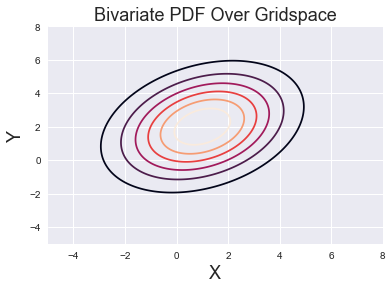

In [3]:
# Construct the PDF of the distribution:
mu = np.array([1,2]);
sigma = np.array([[4,1.2],[1.2,4]])
PDF = scipy.stats.multivariate_normal(mu, sigma)

# Show a contour plot of this distribution:
x,y = np.mgrid[-5:8:.01, -5:8:.01]
pos = np.empty(x.shape + (2,))
pos[:,:,0] = x; pos[:,:,1]=y;
plt.contour(x,y,PDF.pdf(pos))
plt.title('Bivariate PDF Over Gridspace')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://wikimedia.org/api/rest_v1/media/math/render/svg/5d56be4e902ca19613d81ef148989719b38060c7")

In [5]:
Image(url= "https://wikimedia.org/api/rest_v1/media/math/render/svg/f76ccfa7c2ed7f5b085115086107bbe25d329cec")

In [6]:
# Construct the conditionals on this PDF
# Taken from: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions
std1 = np.sqrt(sigma[0,0])
std2 = np.sqrt(sigma[1,1])
p = sigma[0,1]/(std1*std2)

x_given_y = lambda y: scipy.stats.norm.rvs(loc=mu[0] + std1/std2*p*(y-mu[1]),
                                           scale=np.sqrt((1-p**2)*std1**2))
y_given_x = lambda x: scipy.stats.norm.rvs(loc=mu[1] + std2/std1*p*(x-mu[0]),
                                           scale=np.sqrt((1-p**2)*std2**2))

In [7]:
print((1-p**2)*std1**2)
print((1-p**2)*std2**2)

3.64
3.64


In [8]:
# Correlation plot:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
    plt.show()

In [9]:
def plot_gibbs(burn=1000, thin=1):
    Nsamp = 10000 + burn

    # Movement plots
    out=gibbs(x_given_y, y_given_x, Nsamp)
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    plt.hist2d(out[burn::thin,0],out[burn::thin,1], normed=True, bins=100, cmap=cmap)
    plt.contour(x,y,PDF.pdf(pos))
    plt.show()


    nr_t = 100
    plt.contour(x,y,PDF.pdf(pos))
    plt.plot(out[burn:(burn+nr_t), 0],out[burn:(burn+nr_t), 1], '.',alpha=0.8)
    plt.plot(out[burn:(burn+nr_t), 0],out[burn:(burn+nr_t), 1], c='r', alpha=0.5, lw=1)
    plt.show()

    plt.contour(x,y,PDF.pdf(pos))
    sns.kdeplot(out[burn::thin,0],out[burn::thin,1])
    plt.title('KDE Plot Over Original Contour')
    plt.show()

    corrplot(out[:burn,0], 50)
    corrplot(out[:burn,1], 50)

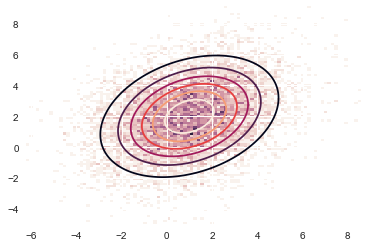

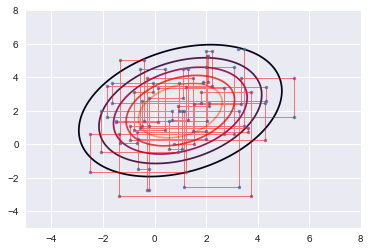

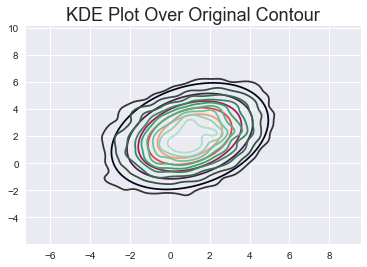

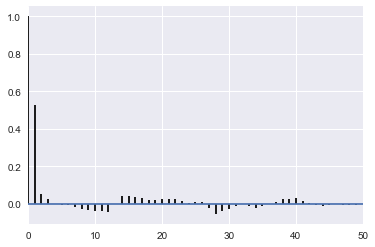

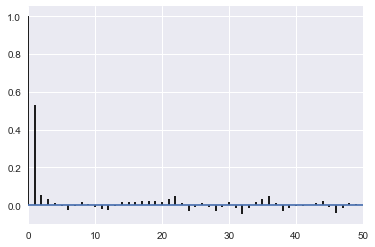

In [10]:
plot_gibbs(burn=2000, thin=1)

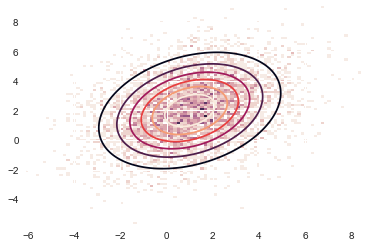

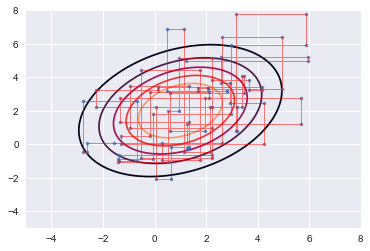

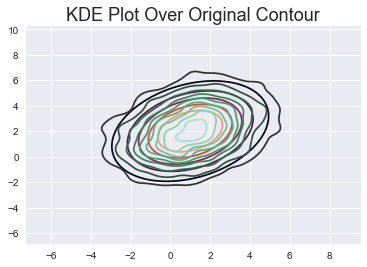

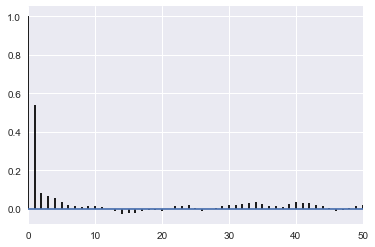

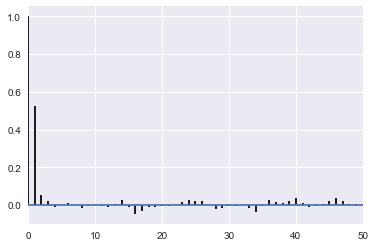

In [11]:
plot_gibbs(burn=5000,thin=2)

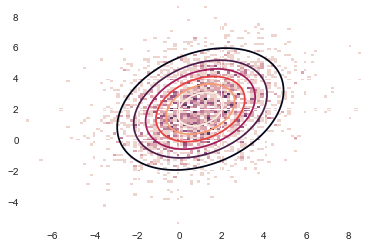

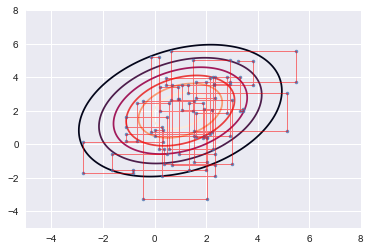

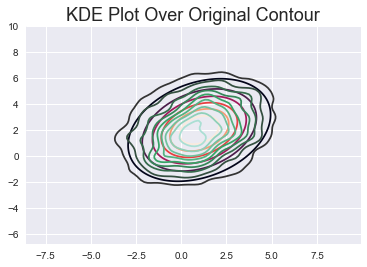

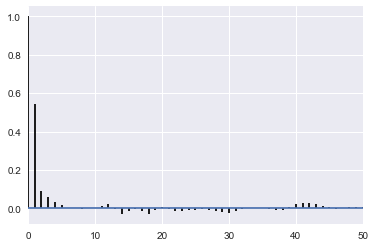

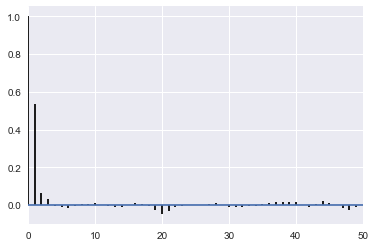

In [12]:
plot_gibbs(burn=10000,thin=4)

### Burn-in and thinning choices:
We know that, based on the setup of the Gibbs problem, we will need to burn-in and thin the output samples due to high levels of auto-correlation. In this particular example, we have chosen two different burn in parameters and two different thinnings and have seen the effects on the autocorrelation. As a result, we choose the burn in parameter of 10000 and a thin of 2.

## Problem 2: Rubber Chickens Bawk Bawk!
In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus1.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus2.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith2.png)

(The images above are also included on canvas in case you are offline, see below)

In the following, we will ask you to compare these two products using the various rating statistics. **Larger versions of the images are available in the data set accompanying this notebook**.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.


### Part A: Inference

1. Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.

2. Write an expression for the posterior pdf, using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. 

  **Note:** The data you will need in order to define the likelihood function should be read off the image files included in the dataset.
  

3. Sample 1,000 values of $\theta$ from the *posterior distribution*.
 
4. Sample 1,000 values of $x$ from the *posterior predictive distribution*.

In [13]:
# Import the data:
count_loftus = 162
loftus = np.array([.67, .17, .06, .04, .06])
count_toysmith = 410
toysmith = np.array([.60, .11, .07, .08, .14])

In [14]:
# Define the Dirichlet prior
from scipy.special import factorial
from scipy.stats import multinomial

## Writing an expression for the posterior PDF
Given the format of the prior as a Dirichlet distribution and the format of the likelihood as a multinomial distribution, we can use Bayes rule to construct the posterior.

Prior: $f(\theta ) = f(\theta | \alpha) = \text{Dir}(\alpha_1...\alpha_k)$

Likelihood: $f(y | \theta) = \text{Mult}(\theta_1...\theta_k)$

Posterior: $f(\theta | y, \alpha) \propto f(y | \theta) \times f(\theta | \alpha)$

Now let's derive the functional form of the posterior.

$
\begin{align}
f(\theta | y) & \propto f(y | \theta) \times f(\theta | \alpha) \\
f(\theta | y) & \propto \text{Mult}(\theta_1...\theta_k) \times \text{Dir}(\alpha_1...\alpha_k) \\
\quad & = \prod_{j=1}^{K} \theta_{j}^{\alpha_{j-1}} \prod_{y_i\in D}\prod_{j=1}^{K} \theta_{j}^{y_i} \\
\quad & = \prod_{j=1}^{K} \theta_{j}^{\alpha_{j} + \sum_{y_i\in D}y_i}
\end{align}
$

Given this, we see that this is in the form of a Dirichlet distribution: $f(\theta|y,\alpha) = \text{Dir}(\alpha'_1...\alpha'_k)$ where $\alpha'_j = \alpha_j + \sum_{y_i\in D} y_i$

## Writing the Posterior Predictive

Getting the posterior predictive:

Let's choose the strategy that we want to predict the set future distribution of observations given a set of  $\theta_i$'s, as in the example from the lab. 

The posterior predictive is defined:

$$
p(\tilde y | Y) = \int_\theta p(\tilde y |\theta,Y) p(\theta|Y,\alpha)d\theta
$$

Where we are marginalizing the $ p(\tilde y |\theta,Y) $ over the posterior for $p(\theta | Y, \alpha)$. To do so, we can simply pass our posterior samples back through the likelihood function and take a single sample at each.

In [15]:
# Now let's create functions for each of these:
alpha = [2, 1, 1, 1, 10]
countL = 162
L = np.array([.06, .04, .06, .17, .67])
    
countT = 410
T = np.array([.14, .08, .07, .11, .60])

prior_frozen = scipy.stats.dirichlet(alpha)

In [16]:
from scipy.stats import gaussian_kde

def run_prediction_Bayes(data, count, name):
    posterior_frozen = scipy.stats.dirichlet(alpha + count*data)

    # Get 1000 values of theta from the prior
    prior_samp = prior_frozen.rvs(size=1000)

    # Plot these values
    for i in range(prior_samp.shape[1]):
        sns.kdeplot(prior_samp[:,i], label=r'$\theta_%d$' % (i+1))

    plt.xlabel(r'$\theta_i$')
    plt.title([name, 'Prior Distribution KDE on 1000 Samples'])
    plt.xlim([0,1])
    plt.legend()
    plt.show()

    # Get 1000 values of theta from this posterior:
    post_samp = posterior_frozen.rvs(size=1000)
    print(name,': Means of Each Theta:', np.mean(post_samp,axis=0))

    # Plot these values
    for i in range(post_samp.shape[1]):
        sns.kdeplot(post_samp[:,i], label=r'$\theta_%d$' % (i+1))

    plt.xlabel(r'$\theta_i$')
    plt.title([name, 'Posterior Distribution KDE on 1000 Samples'])
    plt.xlim([0,1])
    plt.legend()
    plt.show()
    
    # Get 1000 values of the posterior predictive:
    # Now that we have samples from the posterior, we draw yi's from the likelihood from each row of the posterior
    post_pred_samp = np.empty(post_samp.shape)
    for i in range(post_pred_samp.shape[0]):
        post_pred_samp[i,:] = multinomial.rvs(count, post_samp[i,:])

    # Plot the KDE's of the ratings:
    for i in range(post_pred_samp.shape[1]):
        sns.kdeplot(post_pred_samp[:,i], label=r'$y_%d$' % (i+1))

    plt.xlabel(r'$y_i$')
    plt.title([name, 'Posterior Predictive KDE on 1000 Samples'])
    plt.legend()
    plt.show()
    
    return(post_samp, post_pred_samp)

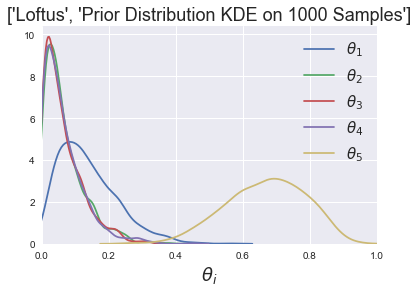

Loftus : Means of Each Theta: [ 0.0666019   0.04238699  0.06111713  0.16046517  0.66942881]


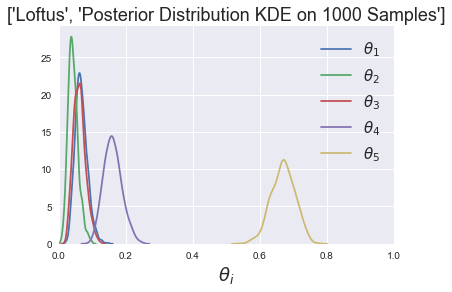

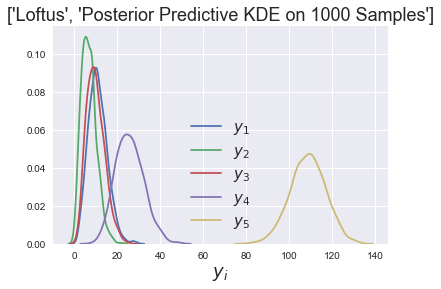

In [17]:
Lpost, Lpostpred = run_prediction_Bayes(L, countL, 'Loftus')

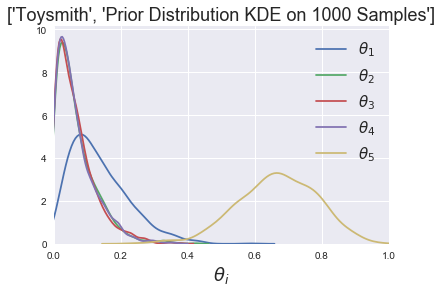

Toysmith : Means of Each Theta: [ 0.14003157  0.07991138  0.06919874  0.10809005  0.60276827]


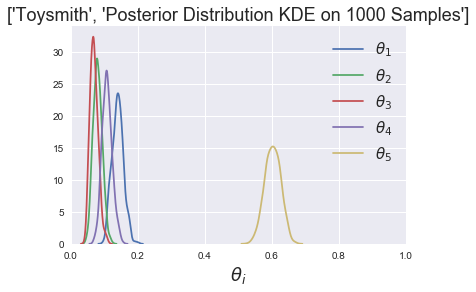

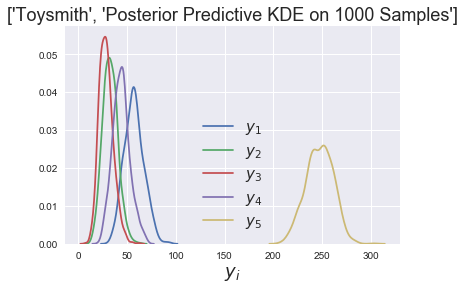

In [18]:
# Toysmith Case:
Tpost, Tpostpred = run_prediction_Bayes(T, countT, 'Toysmith')

### Part B: Ranking

1. Name at least two major potential problems with using only the average customer ratings to compare products.

  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)
  

2. Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

3. Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

4. Finally, which rubber chicken product is superior?

  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)

#### 1. Problems with only using the average customer ratings:
1. The average isn't necessarily a good indicator of the true behavior of the data. For example, a data set with half ratings of 5 and half of 1 is very different than a data set with all ratings at 3. If you were to just compare the average rating of these two products, you would find them to be the same, however, it is not necessarily true that these products are equally well-liked. In this way, you have no way of knowing or weighting polarizing opinions on the product.
2. Similar to the idea that you cannot know about the distribution of the ratings using the average, you similarly have no way of knowing whether this distribution is typical or a-typical. Prior distributions are particularly useful in these cases, as they include information about the expected probabilities of each rating before you have seen any data. These can provide information about how typical or atypical this set of data are considering the model you have generated. This is useful for making judgments on the observed data set as a whole.

#### 2. Using sample from posterior distribution:

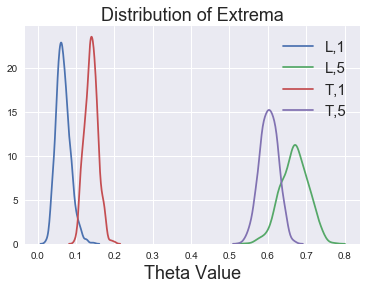

L Posterior Means: [ 0.0666019   0.04238699  0.06111713  0.16046517  0.66942881]
T Posterior Means: [ 0.14003157  0.07991138  0.06919874  0.10809005  0.60276827]
L Expected Rating: 4.32373200514
T Expected Rating: 3.95365207836


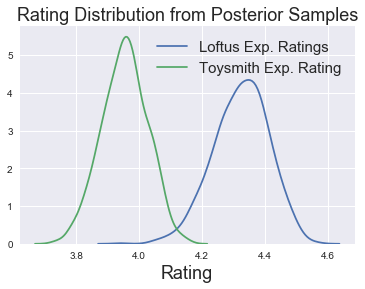

Loftus 80% Credible Interval: [ 4.20776737  4.43345615]
Toysmith 80% Credible Interval: [ 3.85985283  4.04853747]
L MAP Estimate: 4.30329652101
T MAP Estimate: 3.94266546668


In [19]:
# Let's use the samples from the posterior:
ratings = np.arange(1,6)

# 0. Show the distributions for 0 and 1
sns.kdeplot(Lpost[:,0],label='L,1')
sns.kdeplot(Lpost[:,4],label='L,5')
sns.kdeplot(Tpost[:,0],label='T,1')
sns.kdeplot(Tpost[:,4],label='T,5')
plt.title('Distribution of Extrema')
plt.xlabel('Theta Value')
plt.show()

# 1. Calculate the mean of each of the thetas:
print('L Posterior Means:', np.mean(Lpost,axis=0))
print('T Posterior Means:', np.mean(Tpost,axis=0))

# 2. From the theta means, calculate an expected rating:
print('L Expected Rating:', sum(np.mean(Lpost,axis=0) * ratings))
print('T Expected Rating:', sum(np.mean(Tpost,axis=0) * ratings))

# 3. Get the distribution of expected ratings:
Lexp_rating = Lpost @ ratings
Texp_rating = Tpost @ ratings
sns.kdeplot(Lexp_rating, label='Loftus Exp. Ratings')
sns.kdeplot(Texp_rating, label='Toysmith Exp. Rating')
plt.title('Rating Distribution from Posterior Samples')
plt.xlabel('Rating')
plt.show()

# 4. Get some more statistics on the expected rating distribution:
# a) 80% credible interval:
print('Loftus 80% Credible Interval:', np.percentile(Lexp_rating, [10, 90]))
print('Toysmith 80% Credible Interval:', np.percentile(Texp_rating, [10, 90]))

# 5. Get the MAP Estimate:
def get_map(RATING):
    sampleshisto = np.histogram(RATING, bins=50)
    maxcountindex = np.argmax(sampleshisto[0])
    mapvalue = sampleshisto[1][maxcountindex]
    return mapvalue
print('L MAP Estimate:', get_map(Lexp_rating))
print('T MAP Estimate:', get_map(Texp_rating))

Explanation:

Based on the above statistics computed, we have determined that the Loftus product is the better, more well-liked product. The first plot shows that both of the extreme values in the ratings (1 and 5) perform better for the Loftus product when compared to the Toysmith version. We also make this determination based on an estimate of the posterior rating distribution that was then converted into an expected rating score by multiplying the posterior probability samples with the scores themselves. As a result of this analysis, we see that the Loftus 80% credible interval is entirely disjoint (and superior) from that of the Toysmith product. Additionally, the MAP estimates of the Loftus product is larger than that of the Toysmith product.

#### 3. Using sample from posterior predictive distribution:


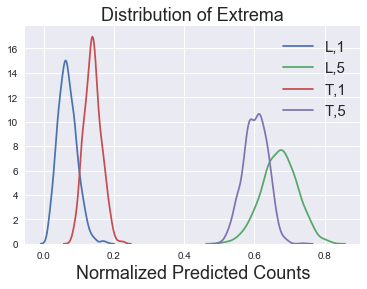

L Posterior Predictive Means: [  10.912    6.724    9.814   25.739  108.811]
T Posterior Predictive Means: [  57.212   32.851   28.585   44.044  247.308]
L Expected Rating: 4.32600617284
T Expected Rating: 3.95459756098


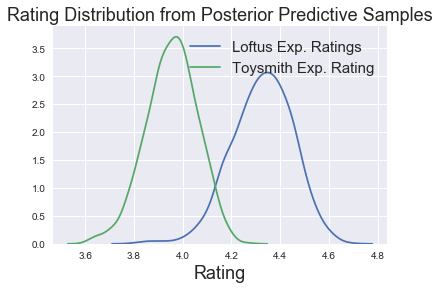

Loftus 80% Credible Interval: [ 4.16666667  4.47530864]
Toysmith 80% Credible Interval: [ 3.8195122   4.08780488]
L MAP Estimate: 4.31345679012
T MAP Estimate: 3.96404878049


In [20]:
ratings = np.arange(1,6)

# 0. Show the distributions for 0 and 1
sns.kdeplot(Lpostpred[:,0]/count_loftus,label='L,1')
sns.kdeplot(Lpostpred[:,4]/count_loftus,label='L,5')
sns.kdeplot(Tpostpred[:,0]/count_toysmith,label='T,1')
sns.kdeplot(Tpostpred[:,4]/count_toysmith,label='T,5')
plt.title('Distribution of Extrema')
plt.xlabel('Normalized Predicted Counts')
plt.show()


# 1. Calculate the mean of each of the thetas:
print('L Posterior Predictive Means:', np.mean(Lpostpred,axis=0))
print('T Posterior Predictive Means:', np.mean(Tpostpred,axis=0))

# 2. From the theta means, calculate an expected rating:
Lsum = sum(Lpostpred.T)
Tsum = sum(Tpostpred.T)
print('L Expected Rating:', sum(np.mean(Lpostpred/Lsum[:,None],axis=0) * ratings))
print('T Expected Rating:', sum(np.mean(Tpostpred/Tsum[:,None],axis=0) * ratings))

# 3. Get the distribution of expected ratings:
Lexp_rating_2 = Lpostpred/Lsum[:,None] @ ratings
Texp_rating_2 = Tpostpred/Tsum[:,None] @ ratings
sns.kdeplot(Lexp_rating_2, label='Loftus Exp. Ratings')
sns.kdeplot(Texp_rating_2, label='Toysmith Exp. Rating')
plt.title('Rating Distribution from Posterior Predictive Samples')
plt.xlabel('Rating')
plt.show()

# 4. Get some more statistics on the expected rating distribution:
# a) 80% credible interval:
print('Loftus 80% Credible Interval:', np.percentile(Lexp_rating_2, [10, 90]))
print('Toysmith 80% Credible Interval:', np.percentile(Texp_rating_2, [10, 90]))

# 5. Get the MAP Estimate:
print('L MAP Estimate:', get_map(Lexp_rating_2))
print('T MAP Estimate:', get_map(Texp_rating_2))

Explanation:

A similar explanation follows from the posterior case and fits the description of the posterior predictive case. It is interesting to note, however, that while the mean of the expected ratings in both companies is approximately the same from looking at the posterior to looking at the posterior predictive, we can see that the MAP estimate has shifted the center of the Toysmith company case towards the right. It is still below the Loftus product, however, and we are still left with the determination that the Loftus product is superior across all of these metrics.

## Problem 3:  Implementing Rat Tumors in pymc3

(it may help to see the bioassay lab to see how to structure pymc3 code, and also the examples from lecture).

Let us try to do full Bayesian inference with PyMC3 for the rat tumor example that we have solved using explicit Gibbs sampling in lab7. Remember that the goal is to estimate $\theta_i$, the probability of developing a tumor in a population of female rats that have not received treatement. 

The posterior for the 70 experiments may be written thus:

$$p( \{\theta_i\}, \alpha, \beta  \vert  Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

Use uniform priors on $[0,1]$ on the alternative variables $\mu$ (the mean of the beta distribution) and $\nu$:

$$\mu = \frac{\alpha}{\alpha+\beta}, \nu = (\alpha+\beta)^{-1/2}$$

You may then write $\alpha$ and $\beta$ as deterministics which depend on $\mu$ and $\nu$.

Here is the data:

In [21]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

In [22]:
# Load in the data
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory_ORG=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn_ORG=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
tumory_ORG, tumorn_ORG

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1,  1,  1,  1,  1,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,
         2,  5,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
        10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
        15,  9]),
 array([20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
        20, 19, 19, 18, 18, 27, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49,
        19, 46, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
        48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
        47, 24]))

In [23]:
# Shuffle the data:
perm_list = np.random.permutation(len(tumory_ORG))
tumory = tumory_ORG[perm_list]
tumorn = tumorn_ORG[perm_list]
tumory, tumorn

(array([ 1,  5,  4,  0,  2,  0,  2,  2, 10,  0,  0,  1,  5,  6,  2,  5,  4,
         0,  3,  4,  4,  5,  3, 15,  0,  7,  0,  4,  6,  1,  4,  4,  3,  0,
         2,  2,  0,  2,  4,  6,  4,  5, 12,  2,  1,  4, 16,  2,  6, 10,  6,
         0,  1, 15,  2,  9,  0,  1,  9,  7,  1,  2, 11,  0,  5,  1,  0,  2,
         0,  1]),
 array([20, 20, 20, 20, 20, 20, 20, 20, 48, 17, 20, 19, 46, 23, 20, 22, 20,
        20, 20, 19, 20, 20, 27, 46, 19, 49, 18, 20, 20, 20, 20, 19, 20, 20,
        20, 17, 20, 25, 20, 20, 20, 49, 49, 13, 18, 19, 52, 24, 22, 50, 20,
        19, 20, 47, 19, 24, 19, 20, 48, 47, 18, 20, 46, 20, 19, 19, 18, 23,
        19, 10]))

In [24]:
from pymc3 import Model

# Get number of experiments
N = len(tumorn)

with Model() as rat_tumor:

    # Secondary Model Parmeters
    mu = pm.Uniform('mu', 0, 1)
    v = pm.Uniform('v', 0, 1)
    
    # Hierarchical Model Parameters
    alpha = pm.Deterministic('alpha', mu/v**2)
    beta = pm.Deterministic('beta', (1-mu)/v**2)
    
    # Rat tumor parameters
    thetas = pm.Beta('thetas', alpha, beta, shape=N)
    
    # Observed tumors
    obs_tumor = pm.Binomial('obs_tumor', n=tumorn, p=thetas, observed=tumory)

In [25]:
rat_tumor.vars # Stochastics

[mu_interval__, v_interval__, thetas_logodds__]

In [26]:
rat_tumor.deterministics # Deterministics

[mu, v, alpha, beta, thetas]

In [27]:
rat_tumor.named_vars # All named variables

{'alpha': alpha,
 'beta': beta,
 'mu': mu,
 'mu_interval__': mu_interval__,
 'obs_tumor': obs_tumor,
 'thetas': thetas,
 'thetas_logodds__': thetas_logodds__,
 'v': v,
 'v_interval__': v_interval__}

In [28]:
# Sample the distributions
with rat_tumor:
   # Sampling function
    stepper=pm.NUTS()
    # Take samples
    traces = pm.sample(10000, step=stepper, njobs=2)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [thetas_logodds__, v_interval__, mu_interval__]
100%|██████████| 10500/10500 [00:46<00:00, 225.07it/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12491bc18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124a5ea90>]], dtype=object)

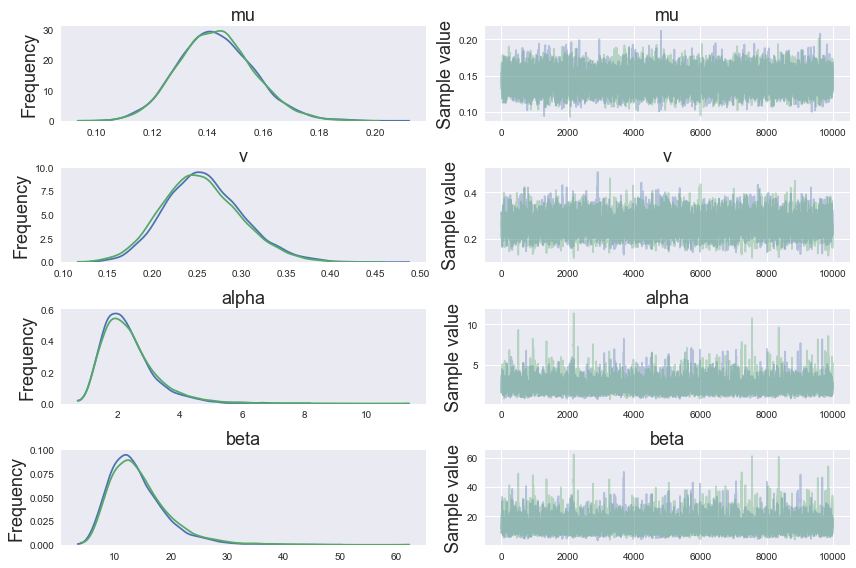

In [29]:
# Show trace plots of the hierarchical variables (not all 70 thetas)
varnames = ['mu', 'v', 'alpha', 'beta']
pm.traceplot(traces, varnames=varnames)

In [30]:
def make_trace(traces, idx):
    fig, ax = plt.subplots(1,2, figsize=(18,3))
    sns.kdeplot(traces['thetas'][:10000,idx], ax=ax[0])
    sns.kdeplot(traces['thetas'][10000:,idx], ax=ax[0])
    ax[0].set_title('Theta %s'%idx)
    ax[0].set_ylabel('Frequency')

    ax[1].plot(traces['thetas'][:10000,idx])
    ax[1].plot(traces['thetas'][10000:,idx],alpha=.3)
    ax[1].set_ylabel('Sample Value')
    ax[1].set_title('Theta %s'%idx)
    plt.show()

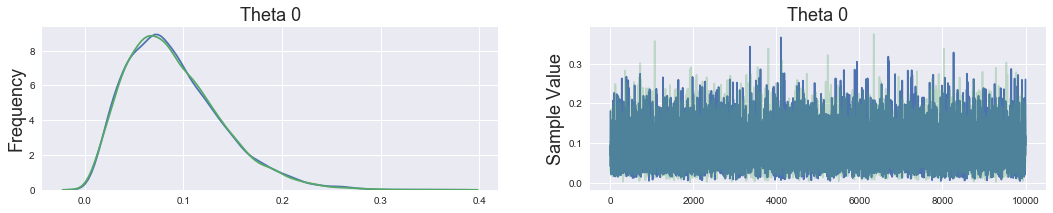

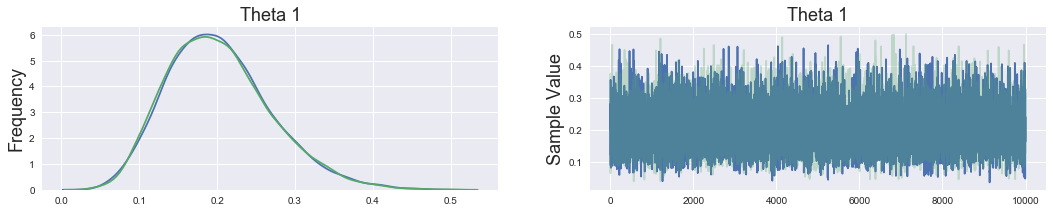

In [31]:
# Trace plots for theta 0 and theta 1
make_trace(traces,0)
make_trace(traces,1)

### Part A:  Report at least the following diagostics on your samples

1. Autocorrelation (correlation dying by lag 20 is fine)
2. Parameter trace correlation after burnin
3. Gewecke
4. Gelman-Rubin
5. $n_{eff}$ (Number of Effective Samples)

Now that we have the model specified, we can look at some of the diagnostics on our samples to make sure they are correct.

The first diagnostic is autocorrelation:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126e433c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x127107d30>]], dtype=object)

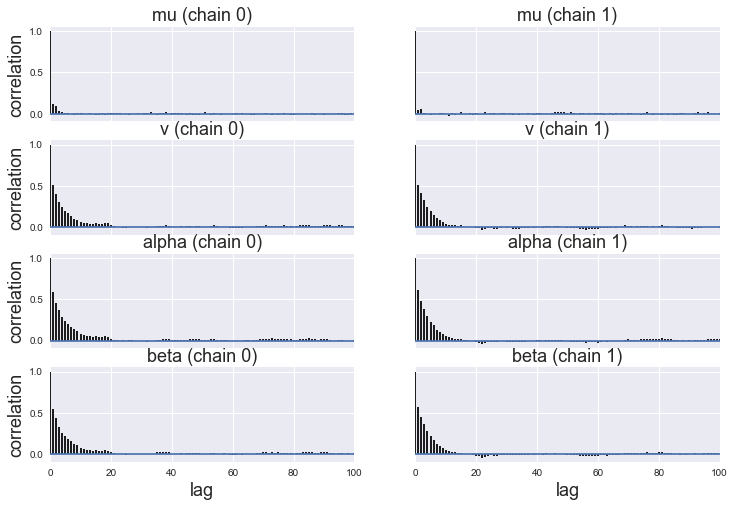

In [32]:
# 1. Autocorrelation plots
pm.autocorrplot(traces, varnames=varnames)

In [33]:
def make_corr(traces, idx):
    fig, ax = plt.subplots(1,2,figsize=(18,2))
    maxlags = 50
    ax[0].acorr(traces['thetas'][:10000,idx] - np.mean(traces['thetas'][:10000,idx]), normed=True, maxlags=maxlags);
    ax[0].set_xlim([0, maxlags])
    ax[0].set_title('Theta %s (Chain 0)'%idx)
    ax[0].set_xlabel('lag')
    ax[0].set_ylabel('Correlation')
    
    ax[1].acorr(traces['thetas'][10000:,idx] - np.mean(traces['thetas'][10000:,idx]), normed=True, maxlags=maxlags);
    ax[1].set_xlim([0, maxlags])
    ax[1].set_title('Theta %s (Chain 1)'%idx)
    ax[1].set_xlabel('lag')
    ax[1].set_ylabel('Correlation')

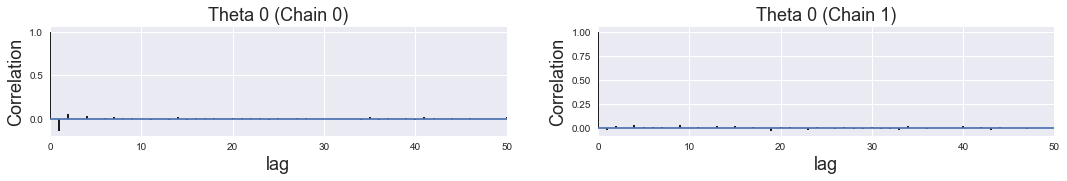

In [34]:
make_corr(traces, 0)

We see that in both of the chains over the hierarchical variables, the autocorrelation dies out by about lag 20, which is exactly what we had specified that we want! We also see that the theta correlation is almost non-existant.

Now: Parameter trace correlation after burnin:

,mu,v,alpha,beta,thetas__0,thetas__1
mu,1.000000,0.185856,0.095027,-0.181618,0.110553,0.102723
v,0.185856,1.000000,-0.889783,-0.927345,-0.152464,0.145544
alpha,0.095027,-0.889783,1.000000,0.956517,0.178183,-0.110835
beta,-0.181618,-0.927345,0.956517,1.000000,0.142955,-0.139565
thetas__0,0.110553,-0.152464,0.178183,0.142955,1.000000,-0.027381
thetas__1,0.102723,0.145544,-0.110835,-0.139565,-0.027381,1.000000


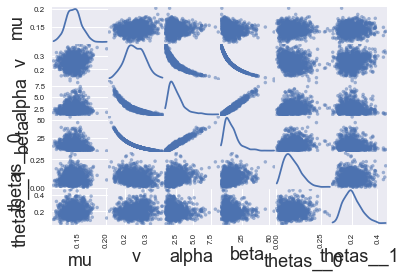

In [35]:
# 2. Parameter trace correlation after burnin:
burn = 1000
df_trace=pm.trace_to_dataframe(traces)
pd.plotting.scatter_matrix(df_trace.iloc[-1000:,0:6], diagonal='kde')
df_trace.iloc[burn::,0:6].corr()


We see in the correlation plots that some of the variables are highly correlated with each other. We notice that mu and v are not correlated, and this validates our intuition as they were sampled from independent uniform distributions. On the other hand, we see a strong correlation between alpha and beta. We notice that this is unavoidable based on the setup of the problem, given that a sample for v fully determines the sum of alpha and beta such that they are unidentifiable. We could attempt to fix this using certain methods, however the correlation will not impact the end result of our model in this case.

Next, we will look at the Geweke statistic:

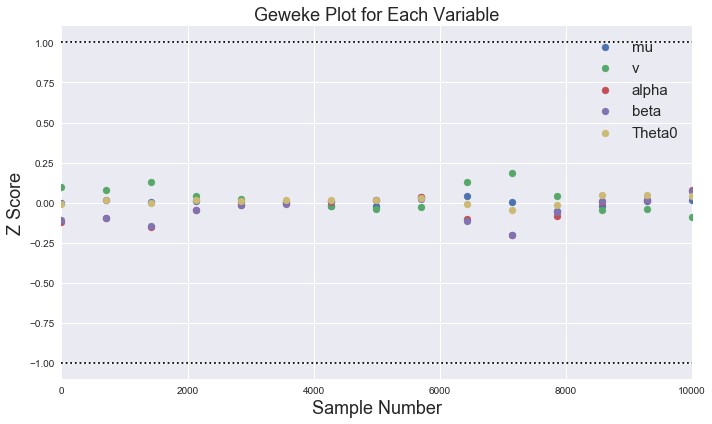

In [36]:
# 3. Geweke Statistic:
plt.figure(figsize=(10,6))
for varn in varnames:
    z = pm.geweke(traces[varn], intervals=15)
    plt.scatter(*z.T, label=varn)

z = pm.geweke(traces['thetas'][:,0], intervals=15)
plt.scatter(*z.T, label='Theta0')

plt.hlines([-1,1], 0, 10000, linestyles='dotted')
plt.xlim(0,10000)
plt.title('Geweke Plot for Each Variable')
plt.xlabel('Sample Number')
plt.ylabel('Z Score')
plt.legend()
plt.tight_layout()
plt.show()



The Geweke statistic tells us how correlated neiboring segments of a chain are to each other. We can see in the plot above that the different segments have some slight correlation given the pattern of the dots over the samples, however, the mean of the Z scores hovers about 0 with small variance, thus we see that the samples are not bad representations and do not possess too much correlation.

Now let's show the Gelman-Rubin statistic:

In [37]:
# 4. Gelman Rubin Statistic
pm.gelman_rubin(traces)

{'alpha': 1.0024249086529406,
 'beta': 1.0022015077984174,
 'mu': 0.99995064111460852,
 'thetas': array([ 0.99995415,  0.99997885,  0.99996005,  1.0003047 ,  0.99998183,
         1.00031771,  0.99997078,  1.0000557 ,  1.00014335,  1.00007755,
         1.00031067,  1.00003056,  1.00035833,  1.00006133,  0.99996638,
         1.00001103,  1.00000596,  1.00005022,  0.99996993,  0.99995085,
         0.99998321,  1.00008485,  1.00016646,  1.00010027,  1.00020497,
         0.99995262,  1.00030394,  1.00001791,  0.99997689,  0.99995483,
         0.99995565,  0.9999903 ,  0.99995787,  1.00000787,  0.99997894,
         0.99996713,  1.00026182,  0.99995017,  0.99996994,  0.99996134,
         1.00000603,  1.0000799 ,  0.99997901,  0.99998271,  1.00009615,
         0.99997486,  1.00006223,  0.99995016,  1.00034757,  1.00014764,
         1.000079  ,  1.00076738,  1.0000167 ,  1.00013933,  1.00016547,
         1.00054909,  1.00024644,  1.00011032,  0.99995035,  0.99996115,
         0.99995173,  0.999

The Gelman Rubin uses multiple chains to check for a lack of convergence. By the definition of the statistic, a Gelman Rubin score of 1 gives us confidence that a particular estimand has converged. We see that each of the Rhat values of the parameters is very close to 1, indicating that we should have a high confidence of convergence.

Now let's look at effective sample size:

In [38]:
# 5. Effective sample size
pm.effective_n(traces)

{'alpha': 2871.0,
 'beta': 3089.0,
 'mu': 14562.0,
 'thetas': array([ 20000.,  18740.,  20000.,  20000.,  20000.,  20000.,  20000.,
         20000.,  20000.,  20000.,  13133.,  20000.,  20000.,  20000.,
         20000.,  20000.,  20000.,  20000.,  20000.,  17584.,  20000.,
         20000.,  17783.,  20000.,  20000.,  20000.,  14328.,  20000.,
         20000.,  20000.,  20000.,  20000.,  20000.,  20000.,  20000.,
         20000.,  20000.,  20000.,  20000.,  19194.,  20000.,  20000.,
         20000.,  20000.,  20000.,  20000.,  20000.,  20000.,  20000.,
         20000.,  20000.,  20000.,  20000.,  15661.,  20000.,  15520.,
         20000.,  20000.,  20000.,  20000.,  20000.,  20000.,  20000.,
         13644.,  20000.,  20000.,  20000.,  20000.,  20000.,  20000.]),
 'v': 3336.0}

In the effective sample size, we see some interesteing behavior that is not quite typical. First, the effective sample size for mu is larger than that of the actual sample size. This is generally indicative of some strong anticorrelations. Additional things to note are that we have low values of effective sample size for alpha and beta, most likely due to the high correlations between model parameters.

Now that we have done ESS, we can look at some other indicators and metrics for fun.

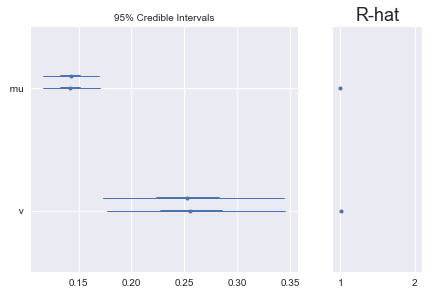

In [39]:
# 6. Forest plots
pm.forestplot(traces, varnames=['mu','v'])

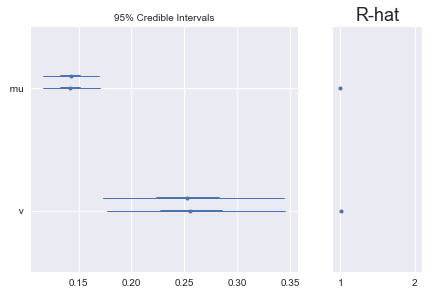

In [40]:
pm.forestplot(traces, varnames=['mu','v'])

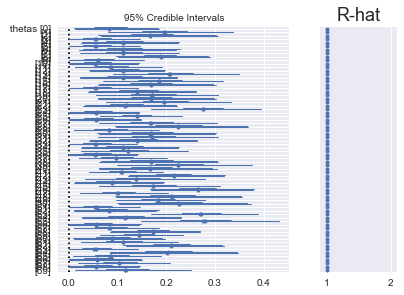

In [41]:
pm.forestplot(traces, varnames=['thetas'])

### Part B:  Posterior predictive check

Recall from lab notes that in a hierarchical model there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $y_i^*$  given a $\theta_i$, and (2) The distribution of observations $y_j^*$  drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).

1. Carry out posterior predictive checks by using `sample_ppc` to generate posterior-predictives for all 70 experiments. This generates predictives of the first type above. 

2. Plot histograms for these predictives with the actual value shown as a red-dot against the histogram (as in the coal disasters model in lecture 14). Is the data consistent with the predictive?

In [42]:
# Sample PPC Check
with rat_tumor:
    tumor_sim = pm.sample_ppc(traces, samples=500)

100%|██████████| 500/500 [00:00<00:00, 2595.95it/s]


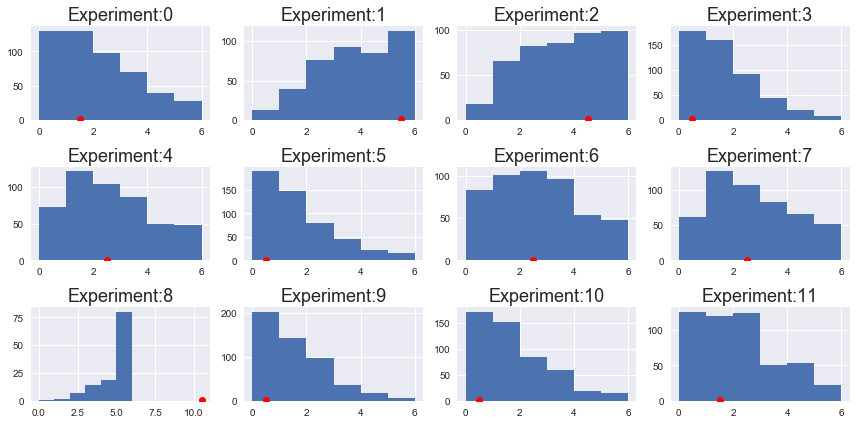

In [43]:
# Plot the histograms for predictives with actual values:
fig, axes = plt.subplots(3, 4, figsize=(12, 6))

for i, (obs, sim, ax) in enumerate(zip(tumory, tumor_sim['obs_tumor'].T, axes.ravel())):
    ax.hist(sim, bins=range(7))
    ax.set_title('Experiment:%d'%i)
    ax.plot(obs+0.5, 1, 'ro')
    
plt.tight_layout()
plt.show()

NOTE: I shuffled the data originally so that I could show more interesting plots than just all zeros.

In the above histograms, I have plotted the posterior predictive on the expected number of deaths in each experiment along with the values for each of the deaths in a select number of experiments. We see that the MAP values of the posterior predictives align well to the actual data that we input into our model.

### Part C:  Shrinkage

1. Plot the posterior median of the death rate parameters $\theta_1, \theta_2, ...\theta_{70}$ against the observed death rates ($y_i/n_i$)

2. Explain the shrinkage by comparing against a 45 degree line as done in the lab.

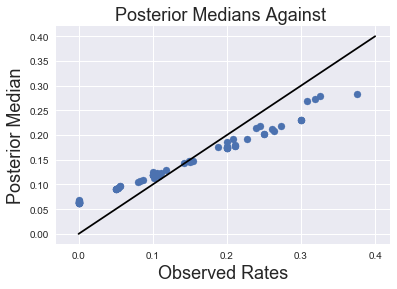

In [44]:
# Get the median values of each of the posteriors on theta:
post_med = np.asarray(traces['thetas']).mean(axis=0)
obs_rates = tumory/tumorn
plt.scatter(obs_rates, post_med)
plt.plot([0,0.4],[0,0.4],'k-')
plt.title('Posterior Medians Against ')
plt.xlabel('Observed Rates')
plt.ylabel('Posterior Median')
plt.show()

Above we have plotted the posterior median of the death rates against the observed death rates. In black is the line y=x showing what a perfect correlation between posterior median and observed rate would look like. We identify that the fact that the slope of the correlation of the rates is smaller than a 1-to-1 correlation means that the model in fact outputs shrinkage of the predictions. Flatness corresponds to complete pooling where there is only one value of theta for the entire set of experiments. In this case, given that we performed partial pooling, we expect some degree of this shrinkage, as theta estimates come from a common prior distribution.

### PART D:  Experiment 71

Consider an additional experiment -- experiment 71 -- in which 4 out of 14 rats died. 

1. Calculate the marginal posterior of $\theta_{71}$, the "new" experiment,

2. Find the $y_{71}^*$ posterior predictive for that experiment.

**HINT: ** The critical thing to notice is that the posterior including the 71st experiment factorizes:

$$p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)  \propto p(y_{71} \vert n_{71}, \theta_{71} ) p(\theta_{71} \vert \alpha, \beta) p(\theta_{1..70}, \alpha, \beta \vert  D)$$

Then we simply marginalize over everything to get the $\theta_{71}$ posterior:

$$p(\theta_{71} \vert \theta_{1..70}, \alpha, \beta, D) = \int d\alpha \,d\beta \,d\theta_{1..70} \,p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)$$

$$=  \int d\alpha \,d\beta  Beta(\alpha+y_{71}, \beta + n_{71} - y_{71})  \int_{\theta_{1..70}} \,d\theta_{1..70} \,p(\theta_{1..70}, \alpha, \beta \vert  D)$$

The $y_{71}^*$ posterior predictive can be found in the usual way.

In [45]:
with rat_tumor:
    theta_new = pm.Beta('theta_new', alpha=alpha, beta=beta)
    obs_new = pm.Binomial('obs_tumor_new', n=14, p=theta_new, observed=4)

In [46]:
# Resample the model
with rat_tumor:
   # Sampling function
    stepper=pm.NUTS()
    # Take samples
    traces_new = pm.sample(10000, step=stepper, njobs=2)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_new_logodds__, thetas_logodds__, v_interval__, mu_interval__]
100%|██████████| 10500/10500 [01:16<00:00, 137.08it/s]
The number of effective samples is smaller than 25% for some parameters.


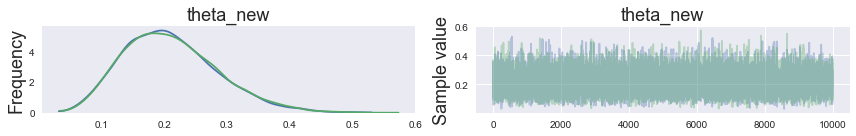

In [47]:
# Plot the new theta traces for the marginal posterior:
pm.traceplot(traces_new, varnames=['theta_new']);

In [48]:
# Posterior Predictive:
with rat_tumor:
    tumor_sim_new = pm.sample_ppc(traces_new, samples=500)

100%|██████████| 500/500 [00:00<00:00, 1208.81it/s]


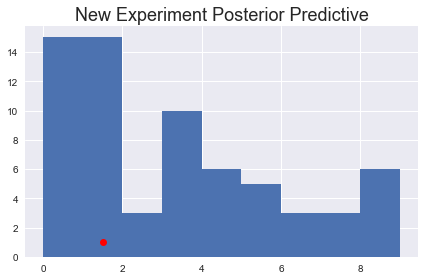

Posterior Predictive Mean: 3.54285714286
Actual Value: 4


In [49]:
# Plot the histograms for predictives with actual values:    
plt.hist(tumor_sim_new['obs_tumor'][-1].T, bins=range(10))
plt.title('New Experiment Posterior Predictive')
plt.plot(tumory[-1]+0.5, 1, 'ro')
plt.tight_layout()
plt.show()

print('Posterior Predictive Mean:',np.mean(tumor_sim_new['obs_tumor'][-1]))
print('Actual Value:', 4)